# Treinamento do Modelo Baseline (LarvaeNet)

Este notebook realiza o treinamento do modelo baseline de convolução para classificação de imagens de larvas.   
O pipeline inclui:
- preparação do dataset
- definição do modelo
- treinamento
- avaliação
- salvamento do modelo treinado
- visualização das projeções
- visualição GRAMCAM.

# Import Dependences

In [ ]:
# instalando torch para gpu integrada do mac - suporte a GPU Metal
# !pip install torch torchvision torchaudio -f https://download.pytorch.org/whl/metal.html

In [1]:
import torch
from torch import nn as nn
import math
from glob import glob
#from torchsummary import summary
from torchinfo import summary
from torch_snippets import *
from torch_snippets.torch_loader import Report
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import train_test_split
import os
import warnings
from larvae_utils import *
from time import time

In [2]:
warnings.filterwarnings("ignore")

In [3]:
# is GPU available?
# gpu = torch.cuda.is_available()
# mudando para verificar gpu integrada do mac
gpu = torch.backends.mps.is_available()

# defining device where to to the computation
device = torch.device("mps") if gpu else torch.device("cpu")
print('Usando device: ', device)

Usando device:  mps


# Dataset and split

In [147]:
orig_dir = '../../figures-datasets/images/larvae'  # changing for larvae folder
nclasses = 2

# Set the desired image size for rescaling and maximum value for normalization
# using the same size as the corel version
width = 224
height = 224
nchannels = 3
maxval = 255.
input_shape = (nchannels, height, width)

# Set percentages for train, validation and test
train_perc = 0.50  # 50% of the dataset for training
valid_perc = 0.20  # 20% of the dataset for validation
test_perc = 0.30  # 30% of the dataset for testing

# get the list of images in the original folder
data = glob(orig_dir+"/*.png")  # it returns a list of image filenames

# Set output model name
model_name = 'LarvaeNetBase.pth'

In [148]:
# checando proporção de targets e não targets (larvae e não larvae)
print("Original dataset:")
check_targets(data)

Original dataset:
Total: 1598
Targets: 247
Não Targets: 1351
Proporção: 0.15456821026282855


In [149]:
# o dataset é desbalanceado, prop de targets = 0.15
# criando split com stratified sampling

labels = [1 if "000001_" in str(x) else 0 for x in data]

# Primeiro split: treino + resto
trainset, temp_set, train_labels, temp_labels = train_test_split(
    data, labels, test_size=(1-train_perc), random_state=42, stratify=labels
)

# Segundo split: validação + teste
valid_size = valid_perc / (valid_perc + test_perc)
validset, testset, valid_labels, test_labels = train_test_split(
    temp_set, temp_labels, test_size=(1-valid_size), random_state=42, stratify=temp_labels
)

In [150]:
print("Trainset:")
check_targets(trainset)
print("Validset:")
check_targets(validset)
print("Testset:")
check_targets(testset)

Trainset:
Total: 799
Targets: 124
Não Targets: 675
Proporção: 0.15519399249061328
Validset:
Total: 319
Targets: 49
Não Targets: 270
Proporção: 0.1536050156739812
Testset:
Total: 480
Targets: 74
Não Targets: 406
Proporção: 0.15416666666666667


In [56]:
# checando proporção de treino, validação e teste
len(trainset)/len(data), len(validset)/len(data), len(testset)/len(data)

(0.5, 0.19962453066332916, 0.30037546933667086)

In [151]:
import pickle

# Salvando os datasets e labels em arquivos .pkl
with open('datasets/trainset.pkl', 'wb') as f:
    pickle.dump({'data': trainset, 'labels': train_labels}, f)

with open('datasets/validset.pkl', 'wb') as f:
    pickle.dump({'data': validset, 'labels': valid_labels}, f)

with open('datasets/testset.pkl', 'wb') as f:
    pickle.dump({'data': testset, 'labels': test_labels}, f)

print("Datasets salvos em arquivos .pkl")

Datasets salvos em arquivos .pkl


## Visualizando exemplos de cada classe

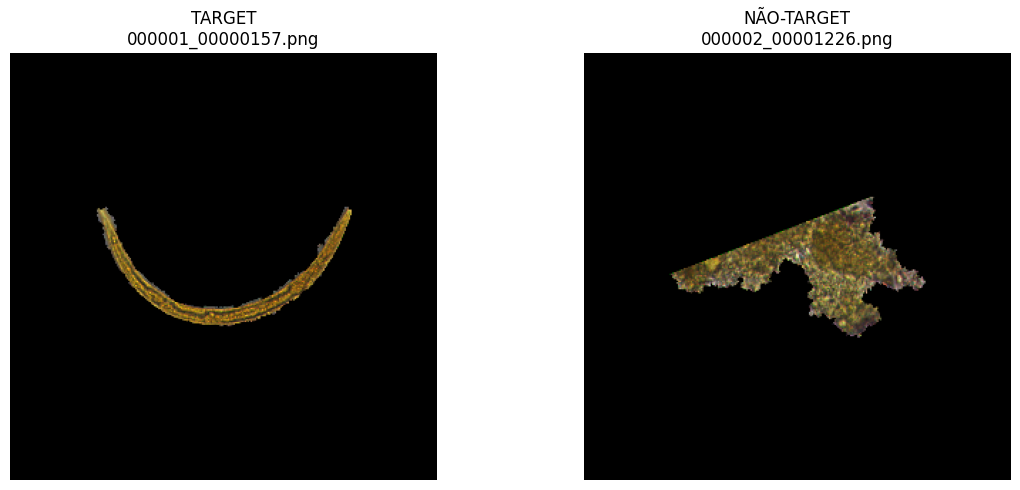

In [8]:
targets = [x for x in data if "000001_" in str(x)]
nao_targets = [x for x in data if "000001_" not in str(x)]

exemplo_target = targets[np.random.randint(0, len(targets))]
exemplo_nao_target = nao_targets[np.random.randint(0, len(nao_targets))]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Imagem Target
img_target = Image.open(exemplo_target)
axes[0].imshow(img_target)
axes[0].set_title(f"TARGET\n{exemplo_target.split('/')[-1]}")
axes[0].axis('off')

# Imagem Não-Target
img_nao_target = Image.open(exemplo_nao_target)
axes[1].imshow(img_nao_target)
axes[1].set_title(f"NÃO-TARGET\n{exemplo_nao_target.split('/')[-1]}")
axes[1].axis('off')

plt.tight_layout()
plt.show()

## Create image datasets

In [ ]:
# Regular preprocessing transformation. The input is a PIL image, which after being resized,
# it is converted into a tensor for normalization using the ImageNet mean and stdev parameters.
prep = transforms.Compose([
    transforms.Resize(
        (224, 224),
        interpolation=transforms.InterpolationMode.BILINEAR,
        max_size=None, antialias=True
    ),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])


# Data augmentation
aug = transforms.Compose([
    # redimensiona a imagem para 300x300
    transforms.Resize(
        (300, 300), 
        interpolation=transforms.InterpolationMode.BILINEAR,
        max_size=None, antialias=True
    ),
    # aplica transformações (rotação, translação, escala e cisalhamento)
    transforms.RandomAffine(
        degrees=10,             # rotação de 10 graus aleatoria
        translate=(0.05, 0.10), # translacao: 5% horizontal e 10% vertical
        scale=(0.9, 1.1),       # escala: 90% a 110% do tamanho original
        shear=(-2, 2),          # cisalhamento: -2 a 2 graus
        interpolation=transforms.InterpolationMode.BILINEAR,  # interpolação bilinear
        fill=0                  # preenche áreas vazias com 0
    ),
    # corta centro da imagem para 250x250
    transforms.CenterCrop(250),
    # redimensiona para 224x224 (tamanho da entrada do modelo)
    transforms.Resize(
        (224, 224), 
        interpolation=transforms.InterpolationMode.BILINEAR,
        max_size=None, antialias=True
    ),
    # converte para tensor
    transforms.ToTensor(),
    # normaliza os valores para o intervalo [0,1]
    transforms.Normalize(
        # media RGB do ImageNet
        mean=(0.485, 0.456, 0.406),
        # dp do ImageNet
        std=(0.229, 0.224, 0.225)
    )
])

# Create an image dataset by applying one of the preprocessing transformations above
class ImageDataset():  
    def __init__(self, dataset, transform=None):
        # it gets the image true labels and set the preprocessing transformation
        self.dataset = dataset
        self.targets = [int(str(x).split("/")[-1].split("_")[0])-1 for x in self.dataset] # larvae = 0, not larvae = 1
        self.transform = transform

    def __len__(self): return len(self.dataset)

    def __getitem__(self, ix):  # returns the item at position ix
        filename = self.dataset[ix]
        target = self.targets[ix]
        image = Image.open(filename)  # It is a PIL image
        if (self.transform is not None):
            image = self.transform(image)
        else:  # just reshape the image as a tensor with nchannels, height, width
            image = torch.from_numpy(np.array(image)).permute(2, 0, 1).float()
        return (image, target)

In [57]:
# verify the difference with and wothout data augmentation
trainset_ = trainset.copy()
validset_ = validset.copy()
testset_ = testset.copy()

trainset = ImageDataset(trainset_, aug)
validset = ImageDataset(validset, prep)
testset = ImageDataset(testset, prep)

# no trainset aplicamos data augmentation (aug)
# no validset e testset aplicamos apenas a normalização (prep)

## Visualize selected images

### Diferences between original image and data aug image from trainset

238


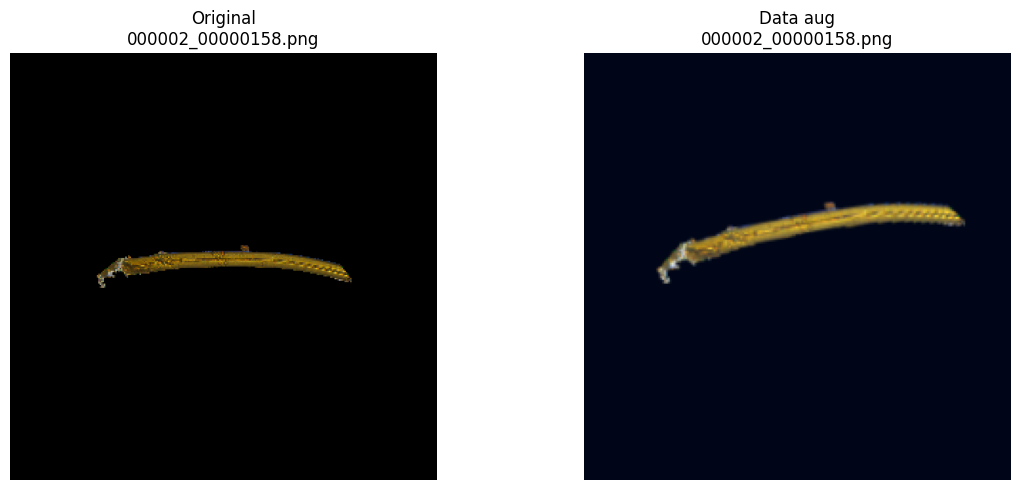

In [11]:
ex = np.random.randint(0, len(trainset_))
print(ex)
exemplo_original = trainset_[ex]
exemplo_transf, target = trainset[ex]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Imagem original
img_original = Image.open(exemplo_original)
axes[0].imshow(img_original)
axes[0].set_title(f"Original\n{exemplo_original.split('/')[-1]}")
axes[0].axis('off')

# Imagem data augmentation
exemplo_transf = exemplo_transf.permute(1, 2, 0).numpy()
exemplo_transf = 255*(exemplo_transf - np.min(exemplo_transf)) / \
    (np.max(exemplo_transf)-np.min(exemplo_transf))
exemplo_transf = exemplo_transf.astype('uint8')
axes[1].imshow(exemplo_transf)
axes[1].set_title(f"Data aug\n{exemplo_original.split('/')[-1]}")
axes[1].axis('off')

plt.tight_layout()
plt.show()

## Generate batches with batchsize images at random

In [12]:
# criando sampler para balancear o treino
# estava enfrentando problemas no treino com a medida de kappa, o que indicava que o modelo estava aprendendo apenas a prever a classe majoritária
# então decidi balancear o treino para ver se melhora a aprendizagem do modelo
from torch.utils.data import WeightedRandomSampler

labels_train = [1 if "000001_" in str(x) else 0 for x in trainset_]
class_sample_count = np.array([len(np.where(np.array(labels_train)==t)[0]) for t in np.unique(labels_train)])
weights = 1. / class_sample_count
samples_weights = np.array([weights[t] for t in labels_train])
sampler = WeightedRandomSampler(samples_weights, len(samples_weights), replacement=True)

In [13]:
batchsize = 32  # batch size = numero de imagens por lote
trainload = DataLoader(trainset, batch_size=batchsize, sampler=sampler)
testload = DataLoader(testset, batch_size=batchsize, shuffle=True)
validload = DataLoader(validset, batch_size=batchsize, shuffle=True)

next(iter(trainload))  # inspect next item in the trainload

[tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           ...,
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
          [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           ...,
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
          [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
           [-

# ConvNet Model

In [14]:
# a convolutional block
# sempre tem convolução + ativação + normalização 
def conv_block(nchannels_in, nchannels_out, stride_val):
    return nn.Sequential(
        # defining convolutional layer
        nn.Conv2d(
            in_channels=nchannels_in, 
            out_channels=nchannels_out, 
            kernel_size=(5, 5),
            stride=1, 
            padding=2, 
            bias=False
        ),
        # defining a batch normalization layer, which dismisses the need for bias in the previous conv layer
        nn.BatchNorm2d(num_features=nchannels_out),
        # defining activation layer
        nn.ReLU(),
        # defining a pooling layer
        nn.MaxPool2d(kernel_size=(3, 3), stride=stride_val, padding=1)
    )


class LarvaeNet(nn.Module):
    def __init__(self, input_shape, num_classes):
        super(LarvaeNet, self).__init__()

        # defining feature extractor (camadas convolucionais)
        self.features = nn.Sequential(
            conv_block(input_shape[0], 32, 2), # 3 canais de entrada, 32 canais de saída, stride=2
            conv_block(32, 256, 2)             # 32 canais de entrada, 256 canais de saída, stride=2
        )

        # defining classifier
        self.classifier = nn.Sequential(
            nn.Linear(
                in_features=input_shape[1]//4*input_shape[2]//4*256, 
                out_features=64, 
                bias=True
            ),
            nn.Dropout(0.30), # overfitou sem dropout
            nn.ReLU(),
            nn.Linear(64, nclasses)
        )

        # initialize weights
        self._initialize_weights()

    def forward(self, x):
       # extracts features
        x = self.features(x)

        # transforms outputs into a 2D tensor
        x = torch.flatten(x, start_dim=1)

        # classifies features
        y = self.classifier(x)

        return y

    def _initialize_weights(self):
        # for each submodule of our network
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # get the number of elements in the layer weights
                n = m.kernel_size[0] * m.kernel_size[1] * m.in_channels
                # initialize layer weights with random values generated from a normal
                # distribution with mean = 0 and std = sqrt(2. / n))
                m.weight.data.normal_(mean=0, std=math.sqrt(2. / n))

                if m.bias is not None:
                    # initialize bias with 0
                    m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                # initialize layer weights with random values generated from a normal
                # distribution with mean = 0 and std = 1/100
                m.weight.data.normal_(mean=0, std=0.01)
                if m.bias is not None:
                    # initialize bias with 0
                    m.bias.data.zero_()

## Create the model

In [15]:
model = LarvaeNet(input_shape, nclasses).to(device)
summary(model)

Layer (type:depth-idx)                   Param #
LarvaeNet                                --
├─Sequential: 1-1                        --
│    └─Sequential: 2-1                   --
│    │    └─Conv2d: 3-1                  2,400
│    │    └─BatchNorm2d: 3-2             64
│    │    └─ReLU: 3-3                    --
│    │    └─MaxPool2d: 3-4               --
│    └─Sequential: 2-2                   --
│    │    └─Conv2d: 3-5                  204,800
│    │    └─BatchNorm2d: 3-6             512
│    │    └─ReLU: 3-7                    --
│    │    └─MaxPool2d: 3-8               --
├─Sequential: 1-2                        --
│    └─Linear: 2-3                       51,380,288
│    └─Dropout: 2-4                      --
│    └─ReLU: 2-5                         --
│    └─Linear: 2-6                       130
Total params: 51,588,194
Trainable params: 51,588,194
Non-trainable params: 0

### Define loss function with L2 regularization

In [16]:
weight_decay = 0.01  # weight decay for regularization
# alterado para 0.01 para tentar melhorar overfitting

def Criterion(model, preds, targets):
    ce = nn.CrossEntropyLoss().to(device)
    loss = ce(preds, targets.long())
    # add l2_regularization
    l2_regularization = 0
    for param in model.parameters():
        l2_regularization += torch.norm(param, 2)
    loss += weight_decay*l2_regularization  # weight_decay
    # compute mean accuracy in the batch
    pred_labels = torch.max(preds, 1)[1]  # same as argmax
    acc = torch.sum(pred_labels == targets.data)
    n = pred_labels.size(0)
    acc = acc/n
    kappa = cohen_kappa_score(pred_labels.cpu().numpy(),targets.data.cpu().numpy())
    return loss, acc, kappa

criterion = Criterion

### Define optimizer and learning scheduler

In [17]:
optimizer = optim.Adam(model.parameters(), lr=2e-4) # alterado de 1e-5 para 2e-4, pois aprendizagem do treino estava muito lenta
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5) # StepLR se saiu melhor que ExponentialLR

In [18]:
## clean up memory if needed
import gc
# del trainset, validset, testset
gc.collect()
torch.cuda.empty_cache()

## Train the model and report results

In [19]:
# train and validate batches foram definidas em larvae_utils.py

# initializing variables
n_epochs = 30
log = Report(n_epochs)

# starting time
start_time = time()
# starting training and validation
for ex in range(n_epochs):
    N = len(trainload)
    for bx, data in enumerate(trainload):
        loss, acc, kappa = train_batch(model, data, optimizer, criterion, device)
        # report results for the batch
        log.record((ex+(bx+1)/N), trn_loss=loss, trn_acc=acc, trn_kappa=kappa, end='\r')

    N = len(validload)
    for bx, data in enumerate(validload):
        loss, acc, kappa = validate_batch(model, data, criterion, device)
        log.record((ex+(bx+1)/N), val_loss=loss, val_acc=acc, val_kappa=kappa, end='\r')

    if (ex+1) % 10 == 0: 
        log.report_avgs(ex+1)
    # count epochs for auto-adjusting the learning rate
    lr_scheduler.step()  # lr decay

training_time = time() - start_time

EPOCH: 10.000  trn_kappa: 0.526  trn_acc: 0.765  val_acc: 0.833  val_loss: 1.430  val_kappa: 0.478  trn_loss: 1.532  (167.33s - 334.66s remaining)
EPOCH: 20.000  trn_kappa: 0.654  trn_acc: 0.829  val_acc: 0.878  val_loss: 1.314  val_kappa: 0.576  trn_loss: 1.371  (329.82s - 164.91s remaining)
EPOCH: 30.000  trn_kappa: 0.681  trn_acc: 0.842  val_acc: 0.865  val_loss: 1.326  val_kappa: 0.597  trn_loss: 1.353  (491.05s - 0.00s remaining)


## Plot results

100%|██████████| 131/131 [00:00<00:00, 16149.48it/s]


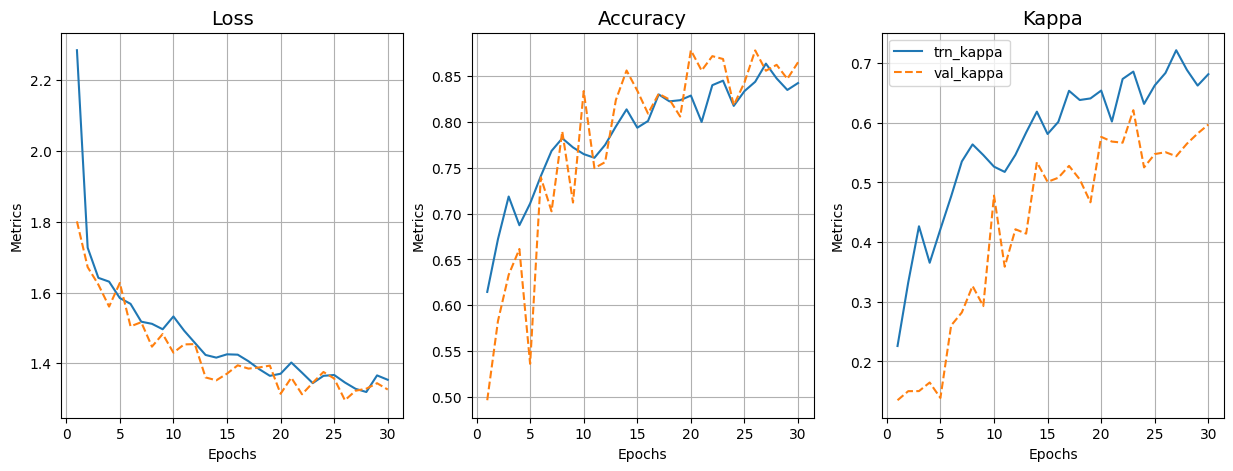

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# plot loss
log.plot_epochs(['trn_loss', 'val_loss'], ax=axes[0])
axes[0].set_title('Loss', fontsize=14)

# plot accuracy
log.plot_epochs(['trn_acc', 'val_acc'], ax=axes[1])
axes[1].set_title('Accuracy', fontsize=14)

# plot kappa
log.plot_epochs(['trn_kappa', 'val_kappa'], ax=axes[2])
axes[2].set_title('Kappa', fontsize=14)

plt.tight_layout
plt.show()

## Evaluate model

In [21]:
# Test defined in larvae_utils.py
(loss, acc, kappa) = Test(model, testload, criterion, device)
print('Loss: {:.6f} Acc: {:.6f} Kappa: {:.6f}'.format(loss, acc, kappa))

Loss: 1.362007 Acc: 0.837500 Kappa: 0.506361


In [22]:
model_name = 'Baseline'

results = {
    'model': model_name,
    'test_loss': loss,
    'test_accuracy': acc,
    'test_kappa': kappa,
    'training_time': training_time,
    'total_parameters': sum(p.numel() for p in model.parameters() if p.requires_grad)
}

results

{'model': 'Baseline',
 'test_loss': 1.3620073874791463,
 'test_accuracy': 0.8375,
 'test_kappa': np.float64(0.5063606294521609),
 'training_time': 491.04807591438293,
 'total_parameters': 51588194}

## Save results and model

In [23]:
import pickle

# Salvar resultados
with open('trained_models2/baseline_results.pkl', 'wb') as f:
    pickle.dump(results, f)

In [24]:
# salvar modelo
torch.save(model.state_dict(), 'trained_models2/Baseline.pth')

# Visualize Results

## Feature Maps

Mostra os mapas de ativação da última camada convolucional para uma imagem.

### For correct classificaction

#### Larvae

In [89]:
# Percorre validset_, salva o target correto, a predição do modelo e o índice
model.eval()
targets_true = []
preds_model = []
indices = []
img_paths = []

with torch.no_grad():
    for idx, (img, target) in enumerate(validset):
        img = img.unsqueeze(0).to(device)
        output = model(img)
        pred = torch.argmax(output, dim=1).item()
        targets_true.append(target)
        preds_model.append(pred)
        indices.append(idx)
        img_paths.append(validset_[idx])

# Criar DataFrame
df_preds = pd.DataFrame({
    'caminho_imagem': img_paths,
    'target_verdadeiro': targets_true,
    'predicao': preds_model,
    'indice': indices
})

df_preds.head()

,caminho_imagem,target_verdadeiro,predicao,indice
0,../../figures-datasets/images/larvae/000002_00...,1,0,0
1,../../figures-datasets/images/larvae/000002_00...,1,0,1
2,../../figures-datasets/images/larvae/000001_00...,0,0,2
3,../../figures-datasets/images/larvae/000001_00...,0,0,3
4,../../figures-datasets/images/larvae/000002_00...,1,0,4


In [95]:
# Verificar um exemplo de classificação da classe de larvas (0) correta da rede no conjunto de teste
idx = df_preds[(df_preds['target_verdadeiro'] == 0) & (df_preds['predicao'] == 0)]['indice'].values[0]
idx

np.int64(2)

In [96]:
validset_[idx] # it is the filename of the image

'../../figures-datasets/images/larvae/000001_00000039.png'

In [97]:
# idx é o índice do exemplo de classificação correta
image, target = validset[idx] # get idx th image from trainset
image.size() # it is a tensor with shape (nchannels, height, width)
image = image.unsqueeze(0) # add batch dimension

In [98]:
# Função para extrair feature map da parte convolucional da rede 
def get_feature_map(model, input_tensor: torch.Tensor) -> torch.Tensor:
    model.eval()
    with torch.no_grad():
        feature_map = model.features(input_tensor) # extrai features da parte convolucional
    return feature_map

In [99]:
feature_map = get_feature_map(model, image.to(device)) # get feature map from the first layer
feature_map.size() # it is a tensor with shape (batch_size, nchannels_out, height_out, width_out)

torch.Size([1, 256, 56, 56])

In [100]:
# salva os feature maps como imagem
# feature_map: tensor com os mapas de características extraídos para cada canal
save_feature_map_as_image(feature_map, 'feature_maps/baseline')  #

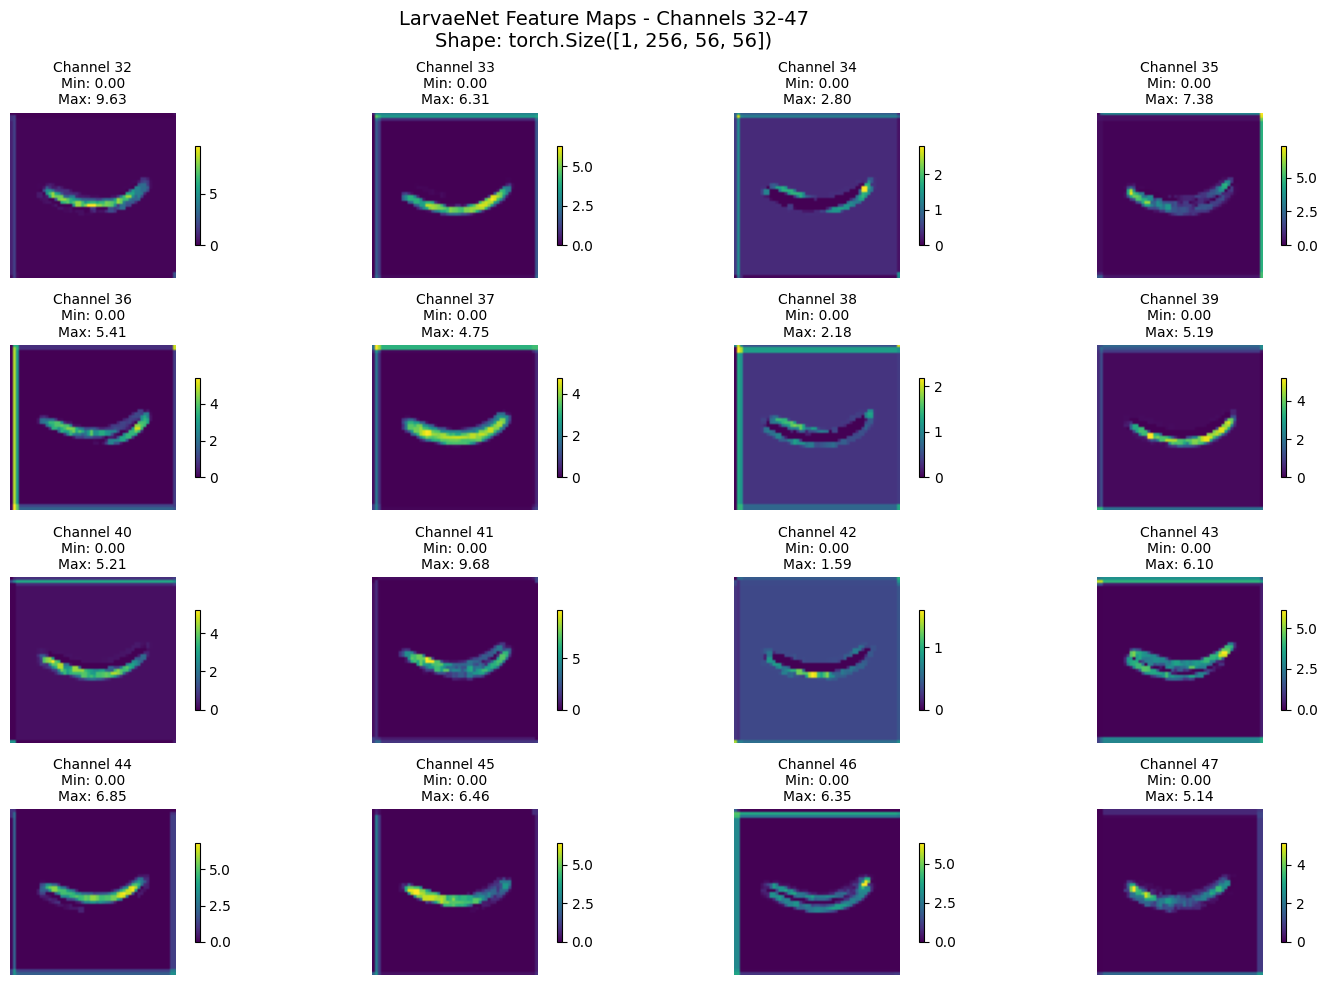

In [101]:
# visualize 16 canais a partir do canal 32
visualize_features(feature_map, max_channels=16, start_channel=32)  

#### Não larva

In [102]:
# se for resto (1) e predicao tambem 1
idx_resto = df_preds[(df_preds['target_verdadeiro'] == 1) & (df_preds['predicao'] == 1)]['indice'].values[0]
idx_resto

np.int64(5)

In [103]:
validset_[idx_resto] # it is the filename of the image

'../../figures-datasets/images/larvae/000002_00000010.png'

In [104]:
# idx é o índice do exemplo de classificação correta
image_resto, target_resto = validset[idx_resto] # get idx th image from trainset
image_resto.size() # it is a tensor with shape (nchannels, height, width)
image_resto = image_resto.unsqueeze(0) # add batch dimension

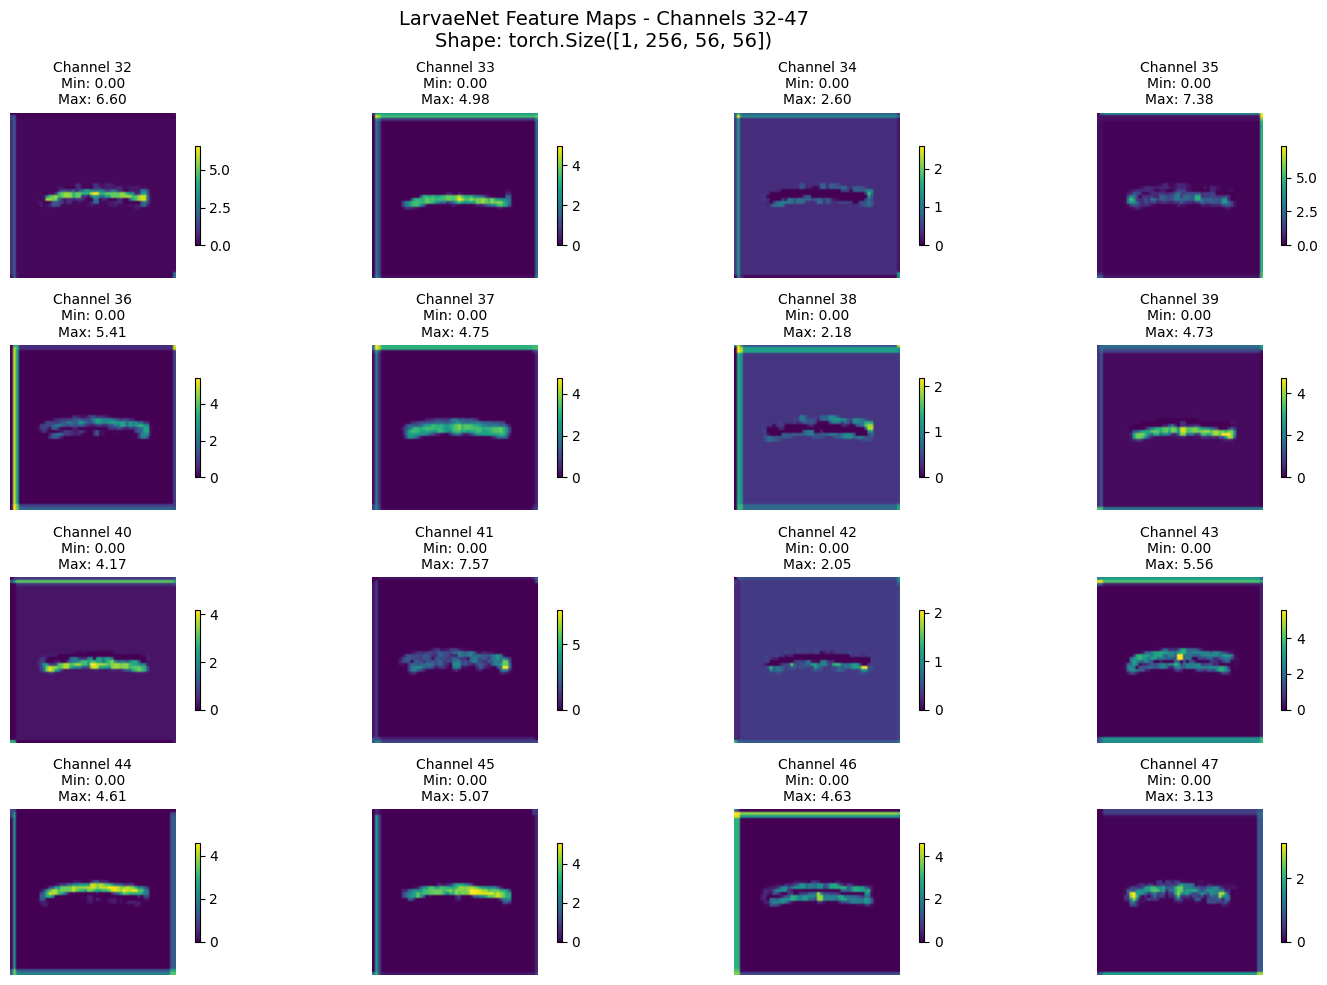

In [105]:
feature_map_resto = get_feature_map(model, image_resto.to(device)) 
visualize_features(feature_map_resto, max_channels=16, start_channel=32)

### For uncorrect classification

#### Larvae

In [106]:
# se larva (0) e predicao resto (1)
idx_error = df_preds[(df_preds['target_verdadeiro'] == 0) & (df_preds['predicao'] == 1)]['indice'].values[0]
idx_error

np.int64(151)

In [107]:
validset_[idx_error] # it is the filename of the image

'../../figures-datasets/images/larvae/000001_00000056.png'

In [108]:
# idx é o índice do exemplo de classificação incorreta
image_error, target_error = validset[idx_error] # get idx th image from trainset
image_error.size() # it is a tensor with shape (nchannels, height, width)
image_error = image_error.unsqueeze(0) # add batch dimension

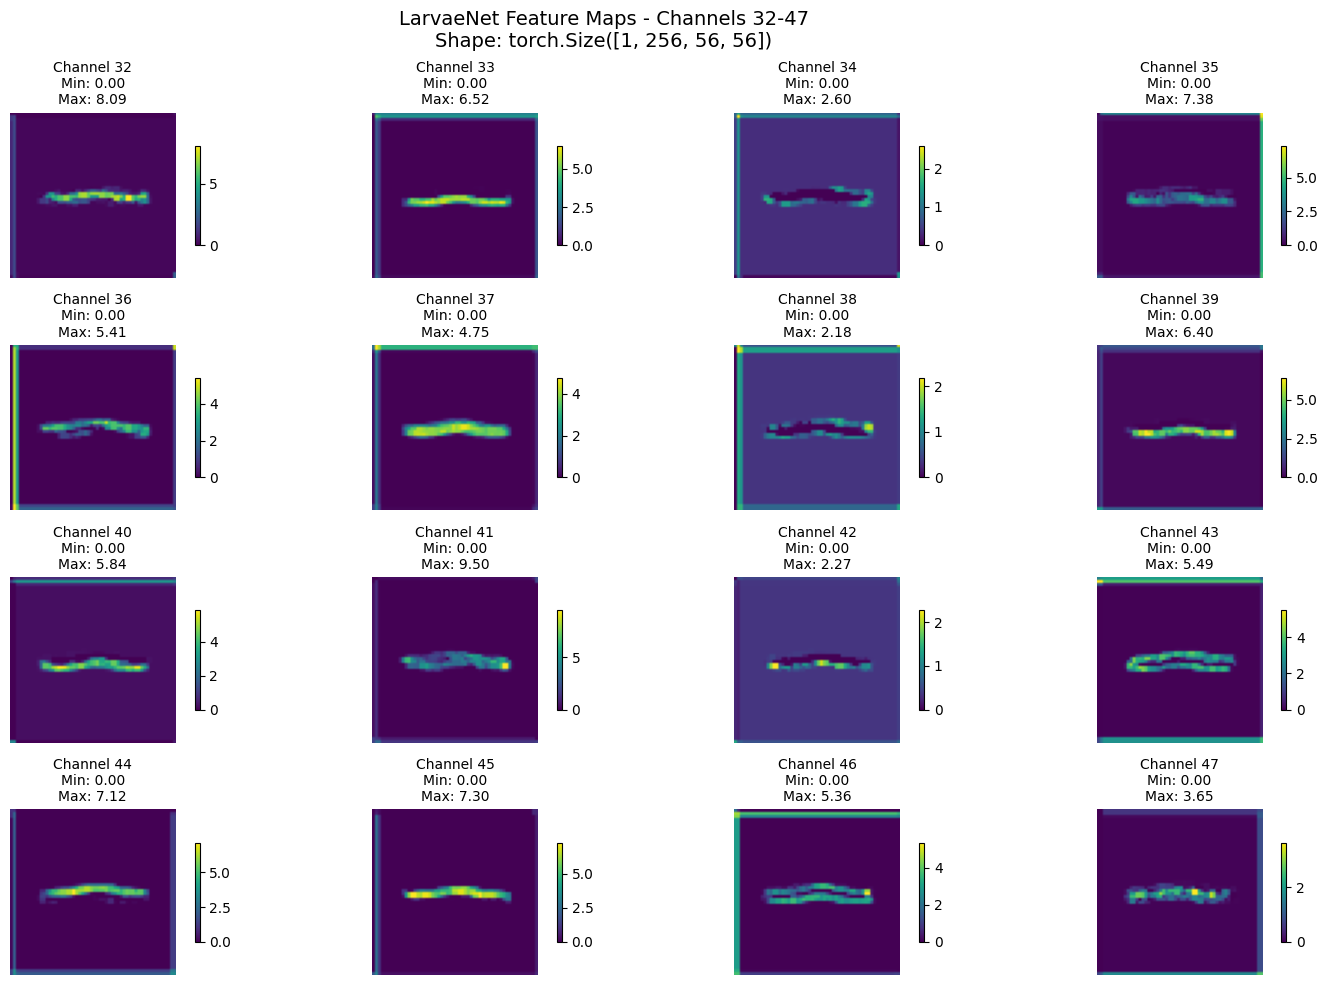

In [109]:
feature_map_error = get_feature_map(model, image_error.to(device)) 
visualize_features(feature_map_error, max_channels=16, start_channel=32)

#### Nao larva

In [110]:
# se for resto (1) e predicao larva (0)
idx_error_resto = df_preds[(df_preds['target_verdadeiro'] == 1) & (df_preds['predicao'] == 0)]['indice'].values[0]
idx_error_resto

np.int64(0)

In [111]:
validset_[idx_error_resto] # it is the filename of the image

'../../figures-datasets/images/larvae/000002_00000302.png'

In [112]:
# idx é o índice do exemplo de classificação incorreta
image_error_resto, target_error_resto = validset[idx_error_resto] # get idx th image from trainset
image_error_resto.size() # it is a tensor with shape (nchannels, height, width)
image_error_resto = image_error_resto.unsqueeze(0) # add batch dimension

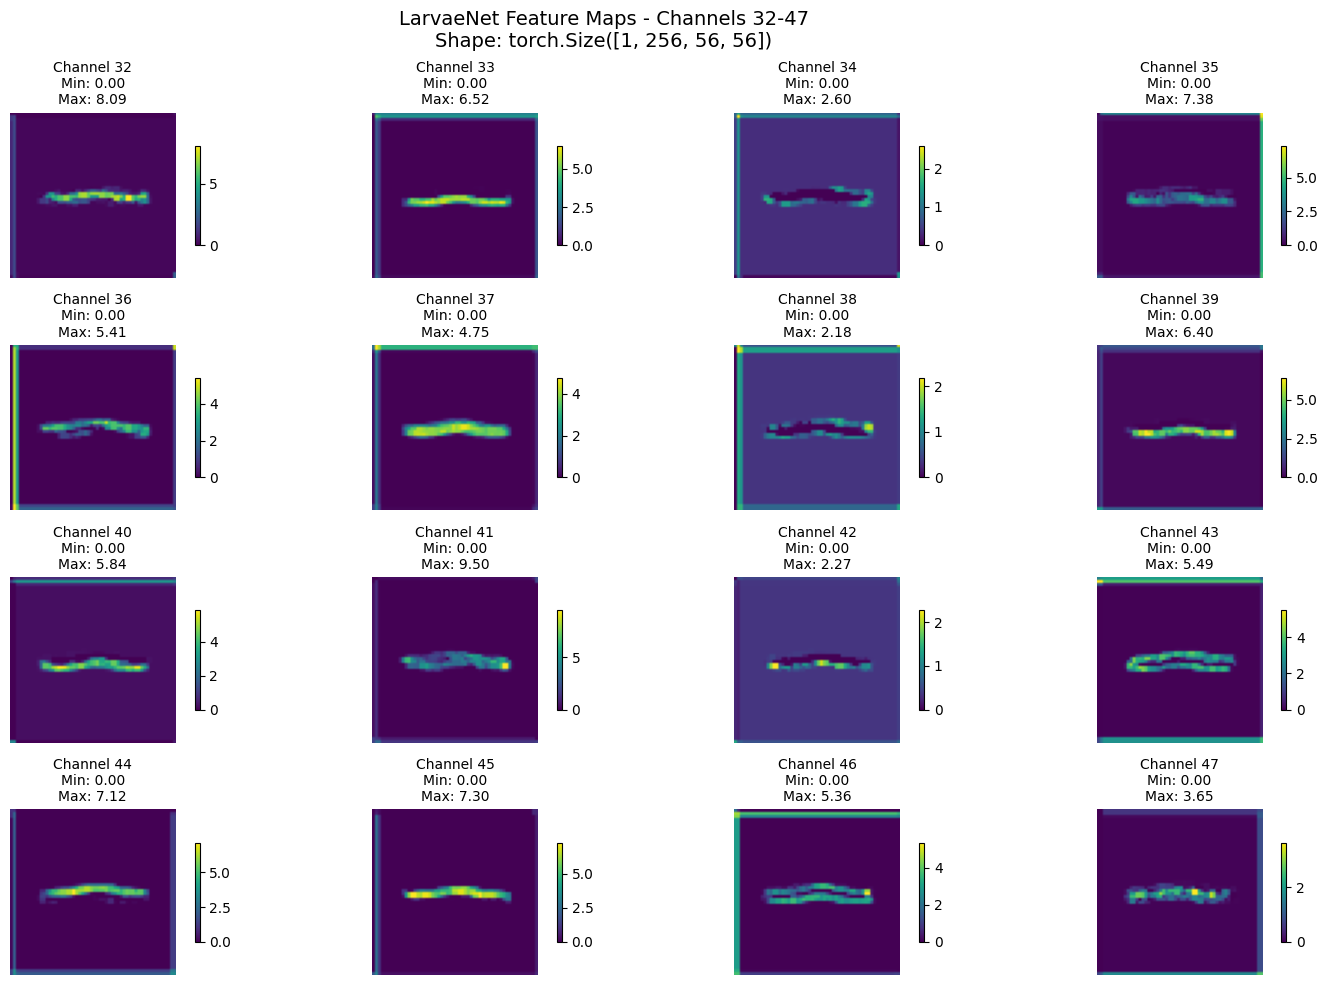

In [113]:
feature_map_error_resto = get_feature_map(model, image_error.to(device)) 
visualize_features(feature_map_error_resto, max_channels=16, start_channel=32)

In [ ]:
# larva classficada como larva
print(validset_[idx]) # =2
# larva classificada como resto
print(validset_[idx_error]) # =151
# resto classificado como resto
print(validset_[idx_resto]) # =5
# resto classificado como larva
print(validset_[idx_error_resto]) # =0

../../figures-datasets/images/larvae/000001_00000039.png
../../figures-datasets/images/larvae/000001_00000056.png
../../figures-datasets/images/larvae/000002_00000010.png
../../figures-datasets/images/larvae/000002_00000302.png


## Projeções Ativações

In [115]:
# function to get the output of each layer/block in convolutional neural network
from collections import OrderedDict
def get_each_output(model, x):
    #empty dict
    output_by_layer = OrderedDict()
  
    #get the input
    output_by_layer['input'] = x.clone().detach().cpu().data.numpy()

    #for each layer of the feature extractor
    for layer_name, layer in model.features.named_children():
        #do forward through the layer   
        x = layer.forward(x)
        #save the output
        output_by_layer["features-"+layer_name] = x.clone().detach().cpu().numpy()

    x = torch.flatten(x, start_dim=1) # flatten the tensor
    output_by_layer['flattened'] = x.clone().detach().cpu().data.numpy()

    #for each layer of the classifier (note that you could have done that for model.conv1 and model.conv2 as well)
    for layer_name, layer in model.classifier.named_children():
        #do forward through the layer   
        x = layer.forward(x)
        #save the output
        output_by_layer["classifier-"+layer_name] = x.clone().detach().cpu().numpy()
  
    #return output by layer
    return output_by_layer

In [116]:
# impoet umap and t-sne
import umap.umap_ as umap
from sklearn.manifold import TSNE
from numpy import broadcast_to

In [118]:
# get the output of each layer
outputs_by_layer, all_labels = get_ouputs(model, validload, device, get_outputs_function=get_each_output)

# get tsne projection
reducer = TSNE(perplexity=30)
projection_by_layer_tsne = projection(outputs_by_layer, reducer)

# get umap projection
reducer = umap.UMAP()
projection_by_layer_umap = projection(outputs_by_layer, reducer)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


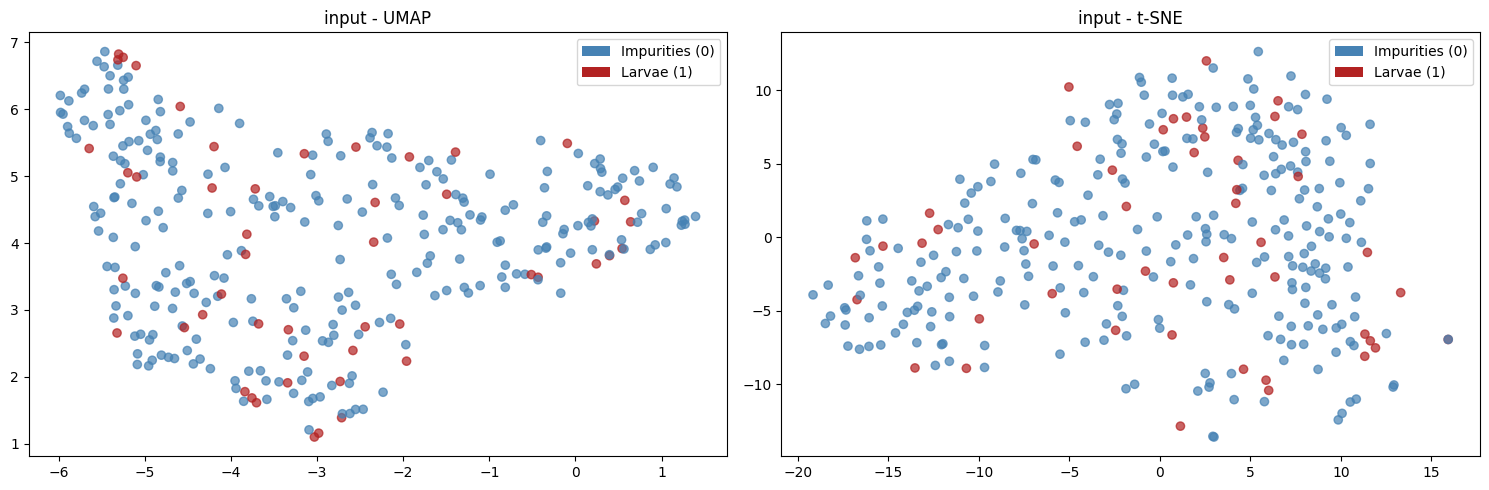

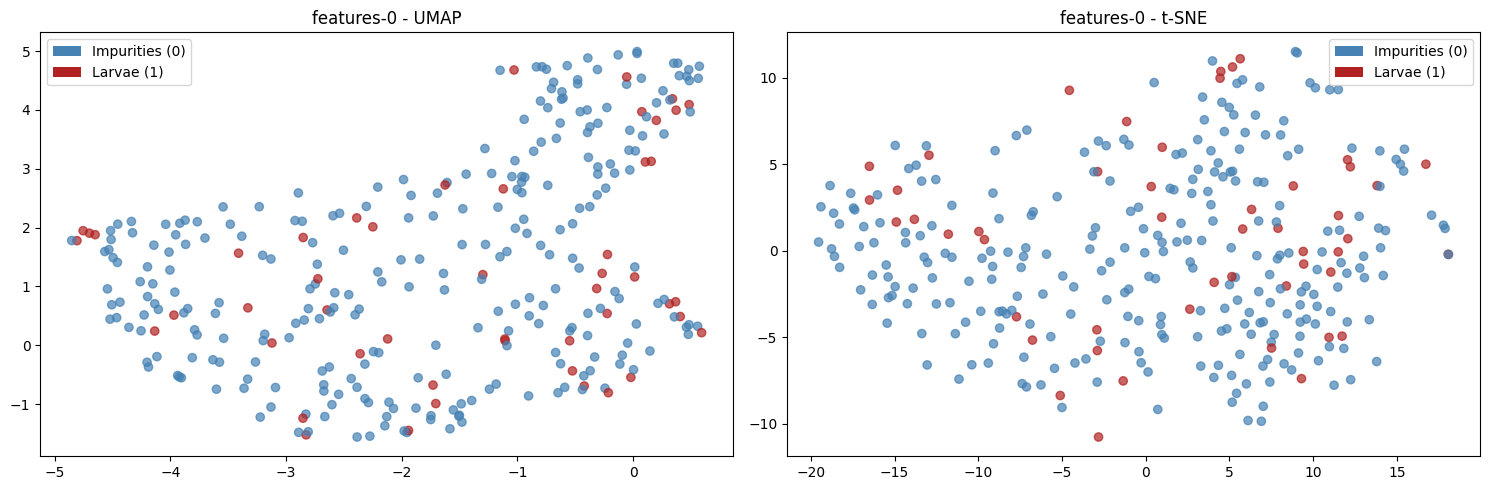

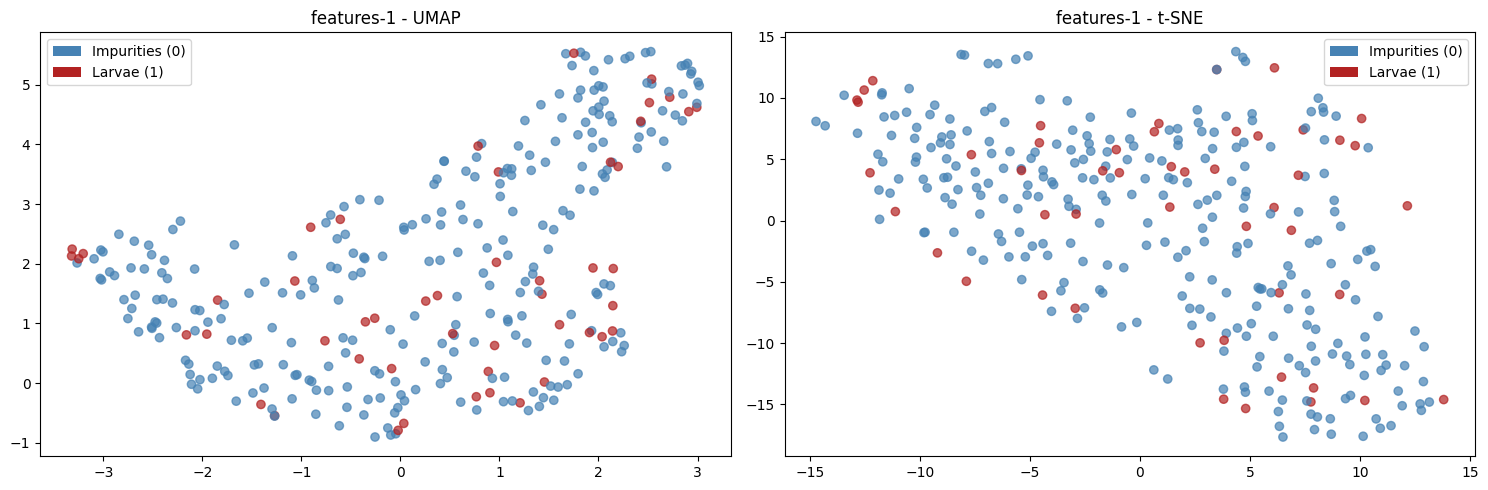

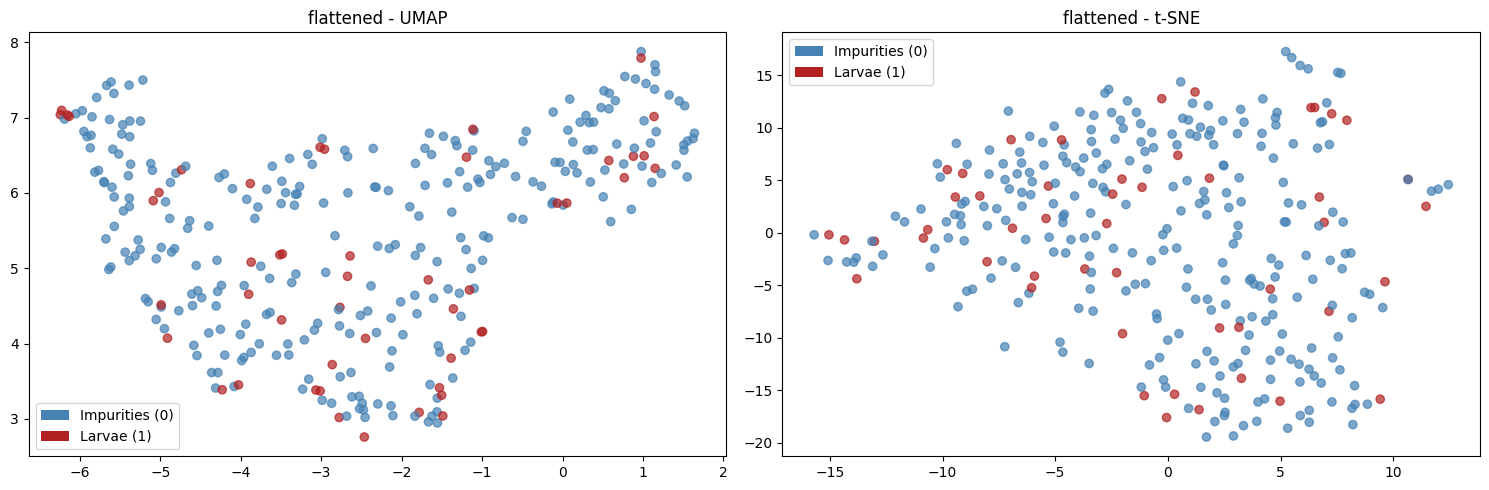

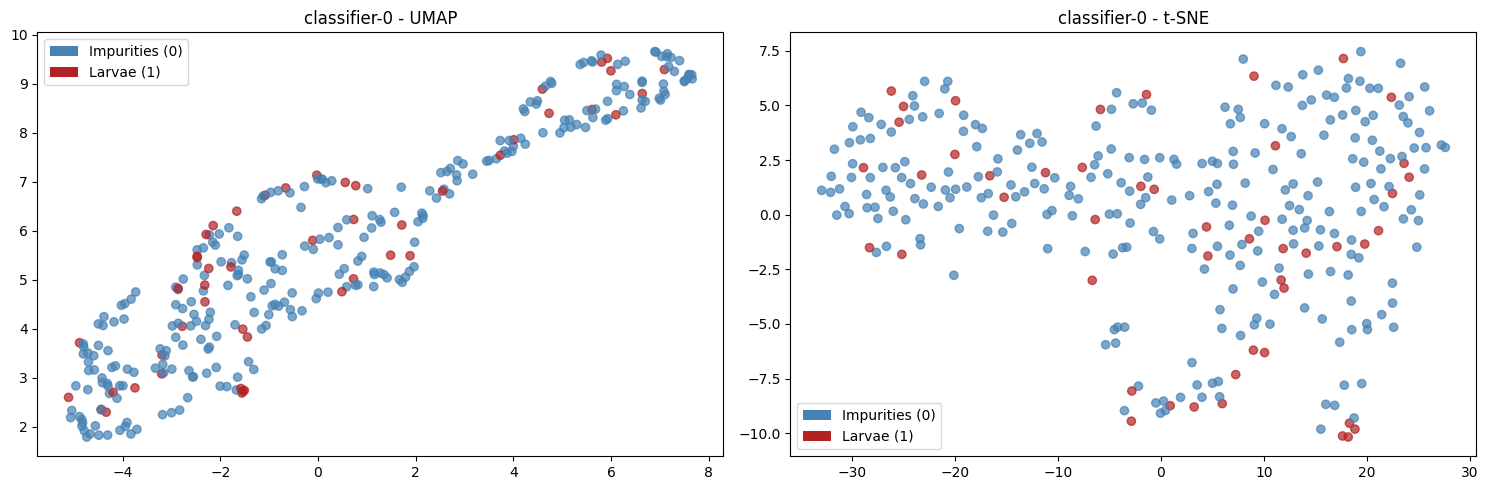

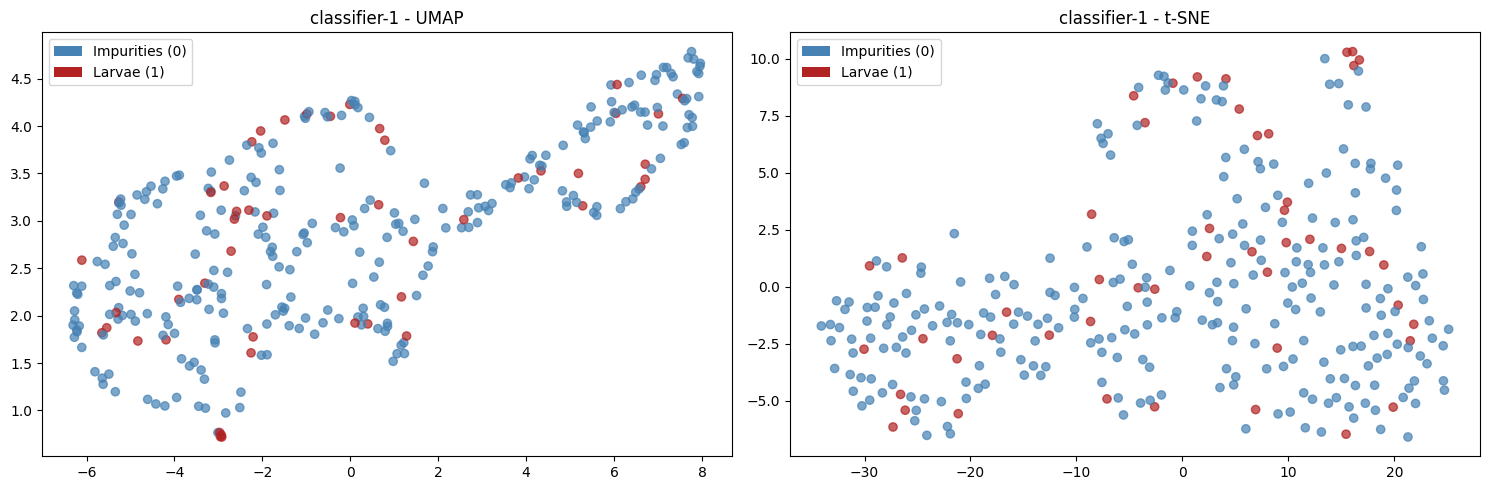

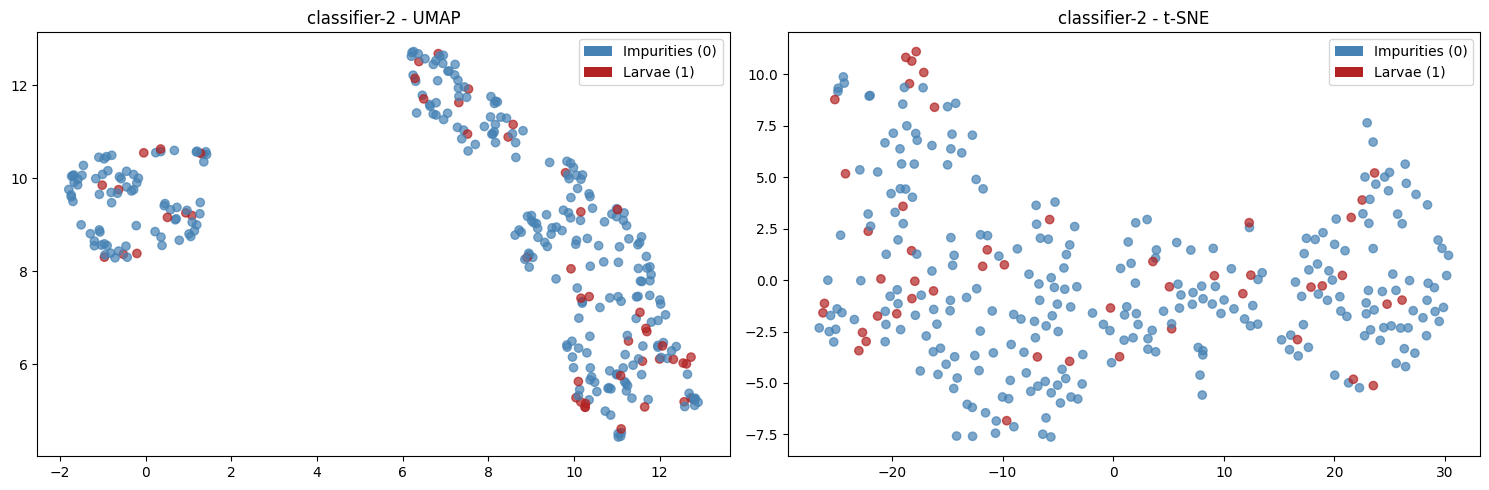

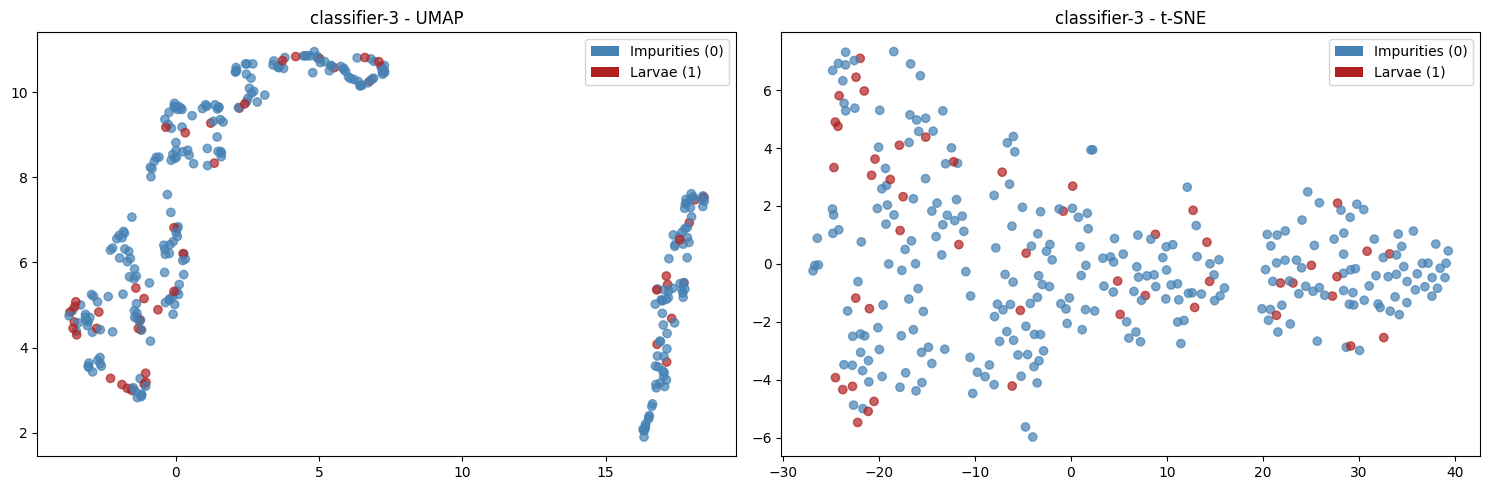

In [123]:
# visualize the projection of the output of each layer
create_visualization(projection_by_layer_umap, projection_by_layer_tsne, valid_labels)

## Regiões de Atenção (GradCAM)

Mostra regiões da imagem que mais influenciaram na decisão do modelo.

In [124]:
import torch.nn.functional as F
import cv2

conv2d_last_block = model.features[1][0] # get the last conv2d block
for name, module in model.named_modules():
    if module is conv2d_last_block:
        target_layer_name = name
        break

# Generate GradCAM for 
# image = exemplo de classificação correta de larva
cam = gradcam_custom_model(model, image.to(device), target_layer_name)
# image_error = exemplo de classificação incorreta de larva
cam_error = gradcam_custom_model(model, image_error.to(device), target_layer_name)
# image_resto = exemplo de classificação correta de resto
cam_resto = gradcam_custom_model(model, image_resto.to(device), target_layer_name)
# image_error_resto = exemplo de classificação incorreta de resto
cam_error_resto = gradcam_custom_model(model, image_error_resto.to(device), target_layer_name)

### Larvas

#### Correto

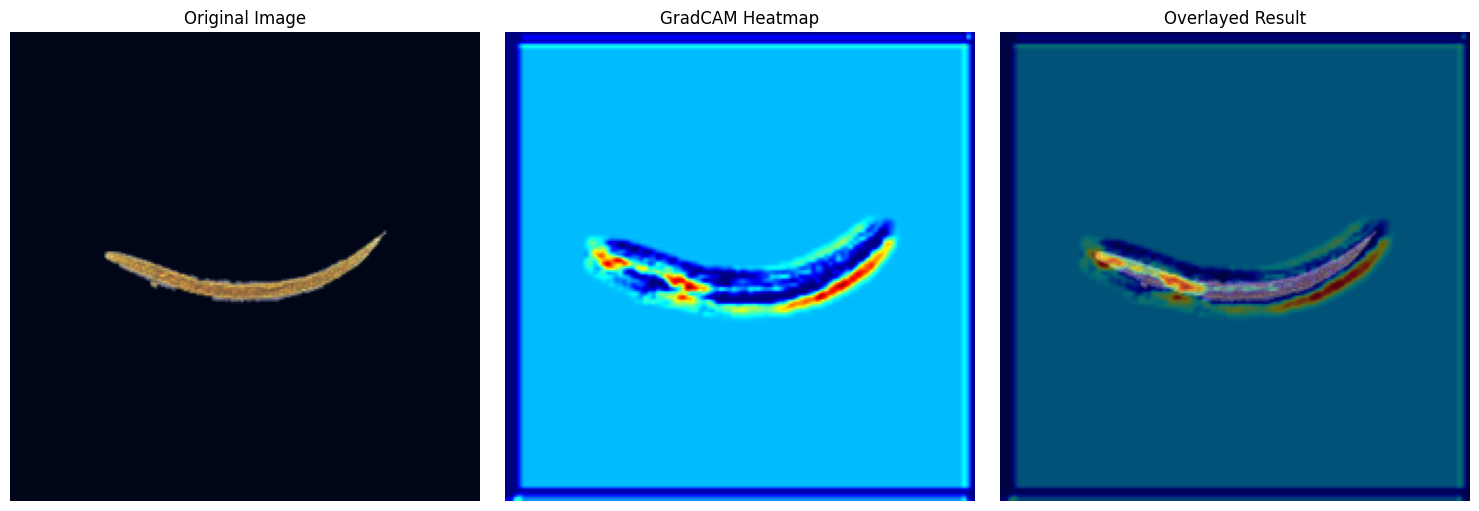

In [128]:
orig_image, target = validset[idx]  
orig_image = orig_image.permute(1, 2, 0).numpy()
orig_image = 255*(orig_image - np.min(orig_image)) / (np.max(orig_image)-np.min(orig_image))
orig_image = orig_image.astype('uint8')
overlayed, heatmap = visualize_gradcam(orig_image, cam, alpha=0.4)

#### Incorreto

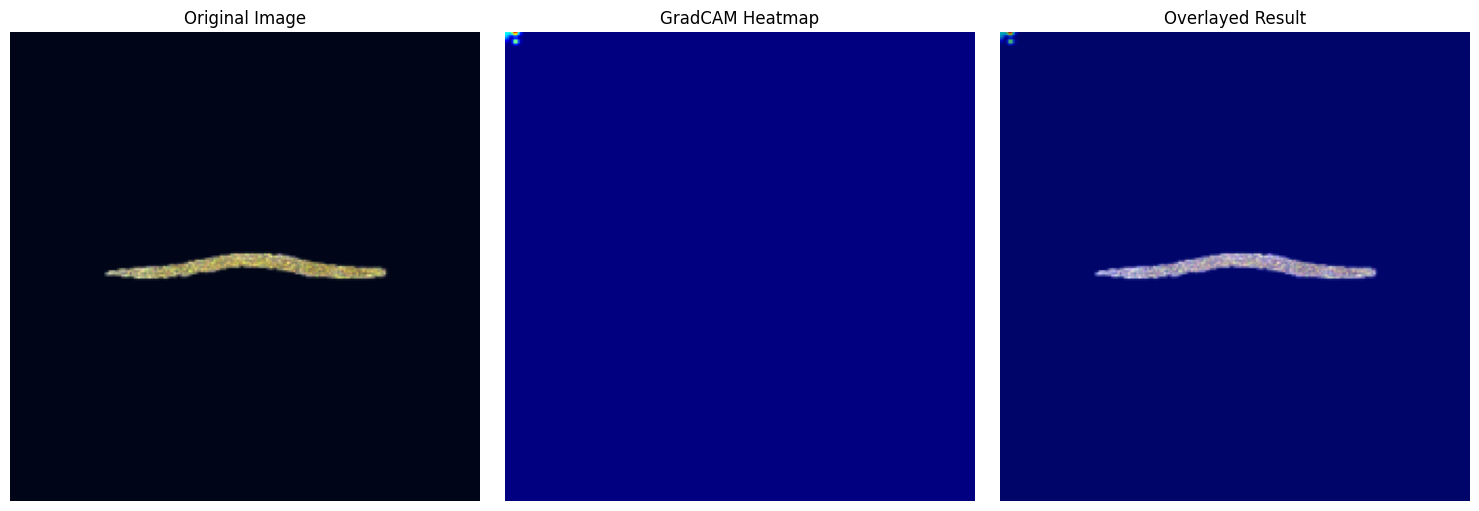

In [129]:
orig_image, target = validset[idx_error]  
orig_image = orig_image.permute(1, 2, 0).numpy()
orig_image = 255*(orig_image - np.min(orig_image)) / (np.max(orig_image)-np.min(orig_image))
orig_image = orig_image.astype('uint8')
overlayed, heatmap = visualize_gradcam(orig_image, cam_error, alpha=0.4)

### Restos

#### Correto

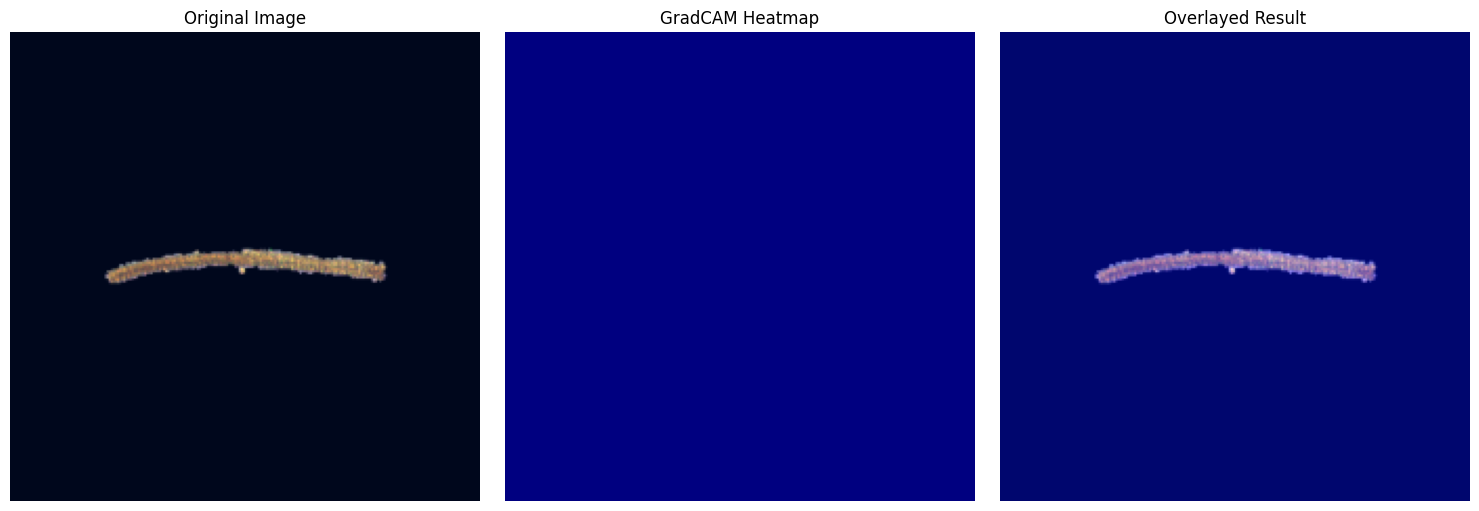

In [131]:
orig_image, target = validset[idx_resto]  
orig_image = orig_image.permute(1, 2, 0).numpy()
orig_image = 255*(orig_image - np.min(orig_image)) / (np.max(orig_image)-np.min(orig_image))
orig_image = orig_image.astype('uint8')
overlayed, heatmap = visualize_gradcam(orig_image, cam_resto, alpha=0.4)

#### Incorreto

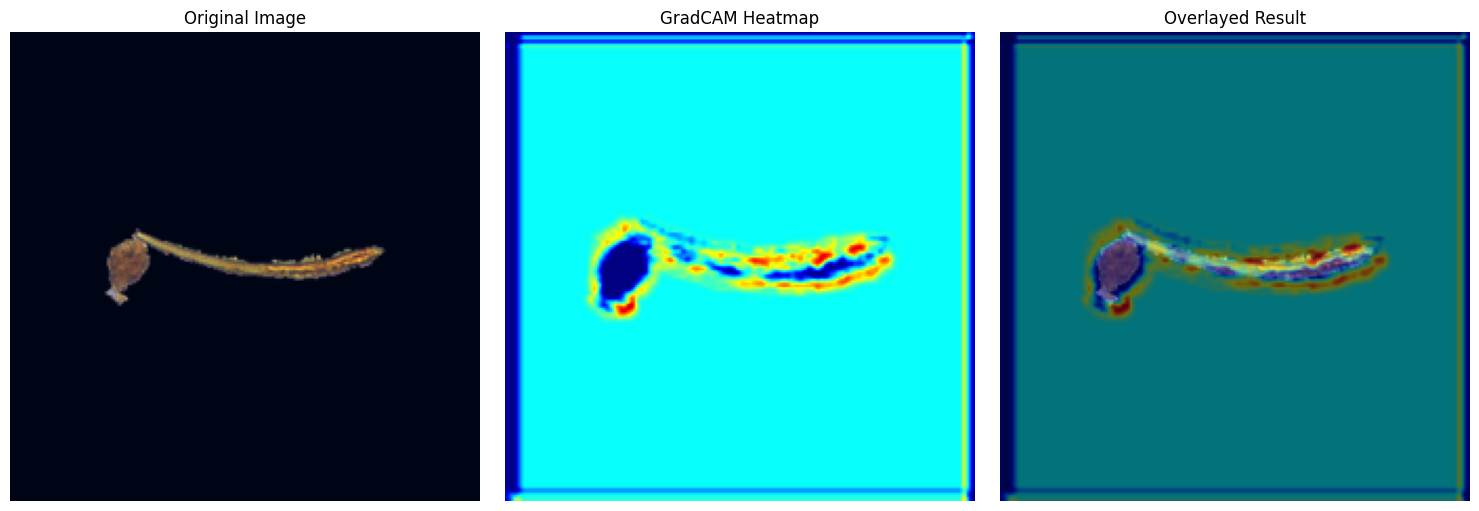

In [132]:
orig_image, target = validset[idx_error_resto]  
orig_image = orig_image.permute(1, 2, 0).numpy()
orig_image = 255*(orig_image - np.min(orig_image)) / (np.max(orig_image)-np.min(orig_image))
orig_image = orig_image.astype('uint8')
overlayed, heatmap = visualize_gradcam(orig_image, cam_error_resto, alpha=0.4)

In [139]:
img_path = '../../figures-datasets/images/larvae/000002_00000013.png'

in_train = img_path in trainset_
in_valid = img_path in validset_
in_test = img_path in testset_

print(f"Está em trainset? {in_train}")
print(f"Está em validset? {in_valid}")
print(f"Está em testset? {in_test}")

Está em trainset? False
Está em validset? True
Está em testset? False


In [140]:
idx_013 = df_preds[df_preds['caminho_imagem'] == img_path]['indice'].values[0]
idx_013

df_preds[df_preds['caminho_imagem'] == img_path]

,caminho_imagem,target_verdadeiro,predicao,indice
163,../../figures-datasets/images/larvae/000002_00...,1,1,163


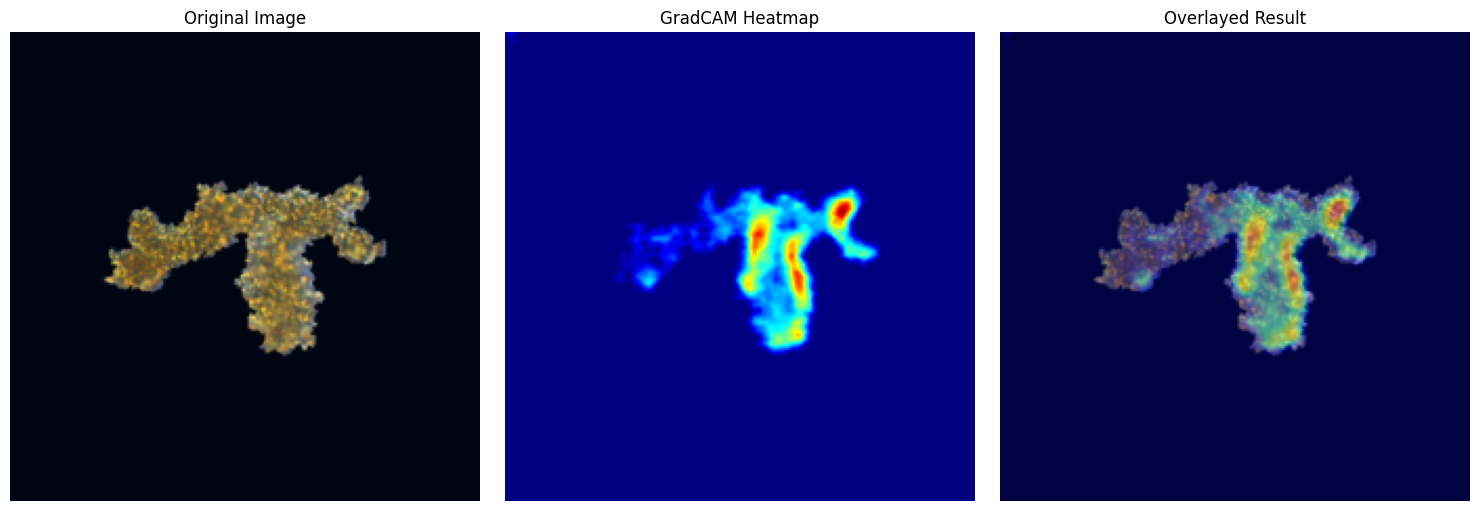

In [141]:
image_013, target_013 = validset[idx_013] # get idx th image from trainset
cam_013 = gradcam_custom_model(model, image_013.unsqueeze(0).to(device), target_layer_name)
image_013 = image_013.permute(1, 2, 0).numpy()
image_013 = 255*(image_013 - np.min(image_013)) / (np.max(image_013)-np.min(image_013))
image_013 = image_013.astype('uint8')
overlayed, heatmap = visualize_gradcam(image_013, cam_013, alpha=0.4)